In [1]:
%pylab inline
from numpy.lib.format import open_memmap
import pandas as pd
import weighted

def find_states(desired_state):
    active_df = pd.DataFrame()
    reader_a = pd.read_csv('ss16pusa.csv',memory_map=True,chunksize=80000)
    for chunk_1 in reader_a:
        active_df = active_df.append(chunk_1[chunk_1['ST']==desired_state])
        if max(chunk_1['ST'])>desired_state:
            break
    reader_b = pd.read_csv('ss16pusb.csv',memory_map=True,chunksize=80000)
    for chunk_1 in reader_b:
        active_df = active_df.append(chunk_1[chunk_1['ST']==desired_state])
        if max(chunk_1['ST'])>desired_state:
            break
    return active_df

Populating the interactive namespace from numpy and matplotlib


In [2]:
def count_by_race(desired_state):
    df = find_states(desired_state)
    wh = np.sum(df['PWGTP'][df['RAC1P']==1])
    bl = np.sum(df['PWGTP'][df['RAC1P']==2])
    return wh,bl

In [3]:
chunk_1 = find_states(27)

This plots a histogram of incomes for all respondants.

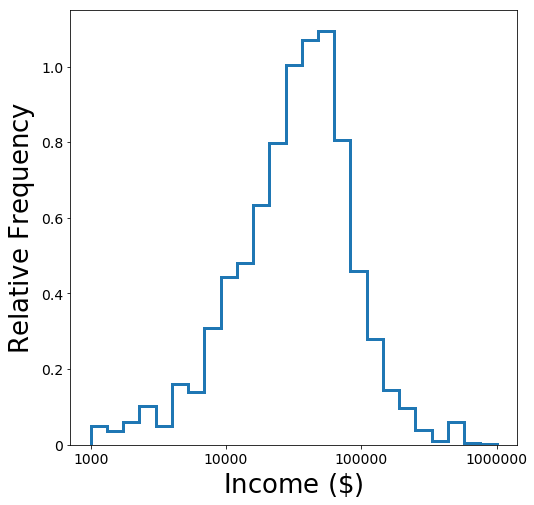

In [15]:
plt.figure(figsize = (6,6))
some_hs = chunk_1[(chunk_1['SCHL']>11)&(chunk_1['AGEP']>18)&(chunk_1['PINCP']>0)]
bl_some_hs = chunk_1[(chunk_1['SCHL']>11)&(chunk_1['RAC1P']==2)&(chunk_1['AGEP']>18)&(chunk_1['PINCP']>0)]
wh_some_hs = chunk_1[(chunk_1['SCHL']>11)&(chunk_1['RAC1P']==1)&(chunk_1['AGEP']>18)&(chunk_1['PINCP']>0)]
plt.figure(figsize=(8,8))
plt.hist(np.log10(some_hs['PINCP']),weights=some_hs['PWGTP'],range=(3,6),bins=25,normed = 1,histtype = 'step',lw = 3)
plt.xlabel(r'$\rm Income \ (\$)$', fontsize = 26)
plt.ylabel(r'$\rm Relative\  Frequency$',fontsize = 26)
ax = plt.gca()
ax.set_xticks([3,4,5,6])
ax.set_xticklabels([1000,10000,100000,1000000],fontsize = 14)
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],fontsize=14)

#plt.text('MN',.1,.8,ax.transAxes())
plt.savefig('Minn.png',bbox_inches='tight')


This looks at income by race, without accounting for confounding variables.

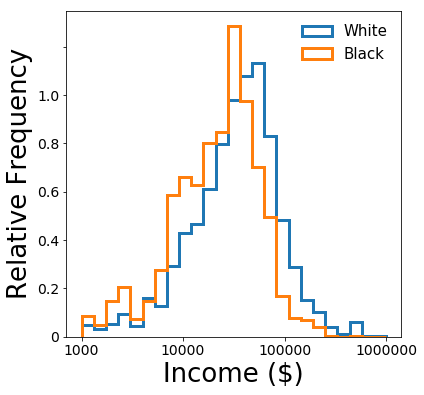

In [16]:
plt.figure(figsize = (6,6))
plt.hist(np.log10(wh_some_hs['PINCP']),weights=wh_some_hs['PWGTP'],range=(3,6),bins=25,normed = 1,histtype='step',label = 'White',lw = 3)
plt.hist(np.log10(bl_some_hs['PINCP']),weights=bl_some_hs['PWGTP'],range=(3,6),bins=25,normed = 1,histtype='step',label = 'Black',lw = 3)
plt.xlabel('Income ($)',fontsize = 26)
plt.ylabel('Relative Frequency',fontsize = 26)
leg = plt.legend(loc = 'best',fontsize = 15)
leg.draw_frame(False)
ax = plt.gca()
ax.set_xticks([3,4,5,6])
ax.set_xticklabels([1000,10000,100000,1000000],fontsize = 14)
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],fontsize=14)

plt.savefig('Minn_race.png',bbox_inches='tight')

In [8]:
all_no_corr   = weighted.median(np.log10(some_hs['PINCP']),weights=some_hs['PWGTP'])
white_no_corr = weighted.median(np.log10(wh_some_hs['PINCP']),weights=wh_some_hs['PWGTP'])
bl_no_corr    = weighted.median(np.log10(bl_some_hs['PINCP']),weights=bl_some_hs['PWGTP'])

Here we look at distributions of education and age by race.

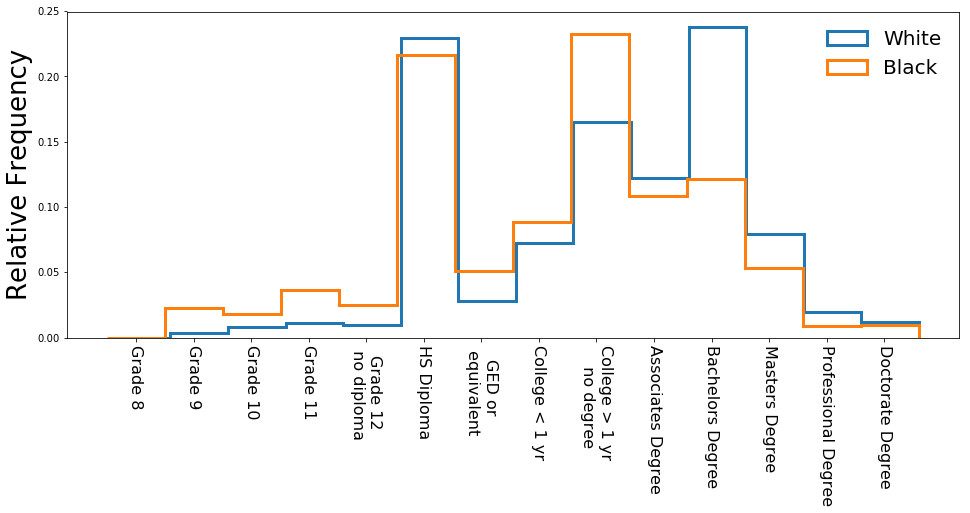

In [18]:
plt.figure(figsize = (16,6))
plt.hist(wh_some_hs['SCHL'],weights=wh_some_hs['PWGTP'],range = (10.6,24.6),bins = 14,normed = 1,histtype = 'step',label = 'White',lw=3)
plt.hist(bl_some_hs['SCHL'],weights=bl_some_hs['PWGTP'],range = (10.5,24.6),bins = 14,normed = 1,histtype = 'step',label = 'Black',lw = 3)
leg = plt.legend(loc = 'best',fontsize = 20)
leg.draw_frame(False)
plt.ylabel('Relative Frequency',fontsize = 26)
plt.xticks(np.arange(14)+11, ('Grade 8', 'Grade 9', 'Grade 10', 'Grade 11', 'Grade 12\n no diploma','HS Diploma','GED or \n equivalent','College < 1 yr','College > 1 yr \n no degree','Associates Degree','Bachelors Degree','Masters Degree','Professional Degree','Doctorate Degree'), rotation=270,fontsize = 16)
plt.savefig('Edu_race.png',bbox_inches = 'tight')

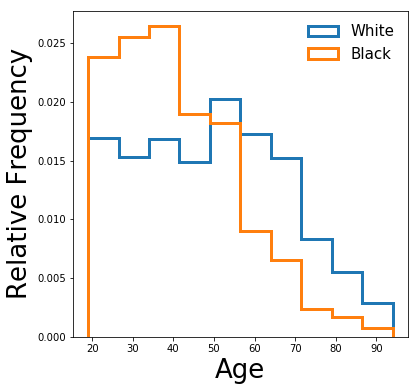

In [20]:
plt.figure(figsize = (6,6))
plt.hist(wh_some_hs['AGEP'],weights=wh_some_hs['PWGTP'],normed = 1,lw = 3,histtype = 'step',label = 'White')
plt.hist(bl_some_hs['AGEP'],weights=bl_some_hs['PWGTP'],normed = 1,lw = 3,histtype = 'step',label = 'Black')
leg = plt.legend(loc = 'best',fontsize = 15)
leg.draw_frame(False)
plt.xlabel('Age',fontsize=26)
plt.ylabel('Relative Frequency',fontsize=26)
plt.savefig('Race_age.png',bbox_inches='tight')

The next few blocks of code create subsamples matched on age, education, and also sex.

In [22]:
cum_weights_white = wh_some_hs['PWGTP']

In [23]:
rand_targets = np.array([np.sum(wh_some_hs['PWGTP'][:i+1]) for i in range(len(wh_some_hs['PWGTP'])+1)])

In [24]:
len_chosen = 14000
chosen = []
acts = np.random.randint(0,rand_targets[-1],len_chosen)
for act in acts:
    finder = rand_targets<=act
    try:
        chosen.append(list(finder).index(False))
    except IndexError:
        chosen.append(-1)
chosen = wh_some_hs.index[chosen]


In [25]:
wh_final = []
bl_final = []
for i in chosen:
    matches = bl_some_hs[(bl_some_hs['AGEP'] == wh_some_hs.loc[i]['AGEP'])&(bl_some_hs['SCHL'] == wh_some_hs.loc[i]['SCHL'])]
    if len(matches) == 0:
        continue
    weighted_matches = np.array([np.sum(matches['PWGTP'][:j+1]) for j in range(len(matches))])
    act_ch = np.random.randint(0,weighted_matches[-1])  
    wh_final.append(i)
    bl_final.append(matches.index[list(act_ch <=weighted_matches).index(True)])

In [26]:
wh_analyze = wh_some_hs.loc[wh_final]
bl_analyze = bl_some_hs.loc[bl_final]

Now we plot a histogram of income by race having corrected for these confounding variables!

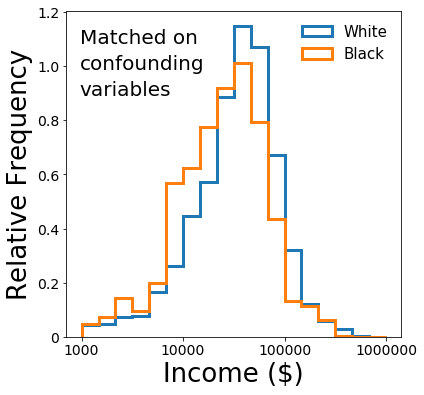

In [38]:
plt.figure(figsize = (6,6))
plt.hist(np.log10(wh_analyze['PINCP']),normed = 1,histtype = 'step',label = 'White',lw = 3,range=(3.,6.),bins=18)
plt.hist(np.log10(bl_analyze['PINCP']),normed = 1,histtype = 'step',label = 'Black',lw = 3,range=(3.,6.),bins=18)
plt.xlabel('Income ($)',fontsize = 26)
plt.ylabel('Relative Frequency',fontsize = 26)
leg = plt.legend(loc = 'best',fontsize = 15)
leg.draw_frame(False)
ax = plt.gca()
ax.set_xticks([3,4,5,6])
ax.set_xticklabels([1000,10000,100000,1000000],fontsize = 14)
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0,1.2],fontsize=14)
plt.text(.04,.90,'Matched on',transform=ax.transAxes,fontsize=20)
plt.text(.04,.82,'confounding',transform=ax.transAxes,fontsize=20)
plt.text(.04,.74,'variables',transform=ax.transAxes,fontsize=20)

plt.savefig('matched.png',bbox_inches='tight')

In [55]:
10**np.median(np.log10(wh_analyze['PINCP']))

38000.0

In [56]:
10**np.median(np.log10(bl_analyze['PINCP']))

26000.000000000015